# Introduction

A time series can be made up of three key components.
- Trend: A long-term increase or decrease are termed trends.
- Seasonality: An effect of seasonal factors for a fixed or known period. For example, retail stores sales will be high during weekends and festival seasons.
- Cycle: These are the longer ups and downs that are not of fixed or known periods caused by external factors.

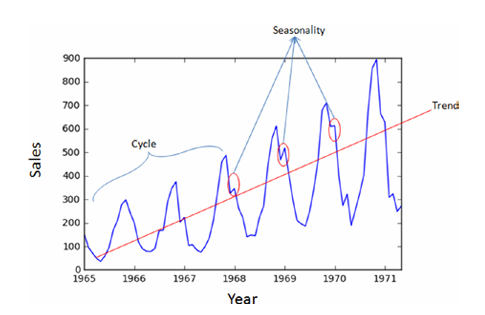

Autocorrelation is a statistical concept that measures the correlation of a signal with a delayed copy of itself over varying time intervals. In simpler terms, it assesses how the values of a time series are related to their own past values.

Lag: Autocorrelation is calculated at different "lags," which refer to the time intervals between observations. For example, a lag of 1 would compare a value to the value immediately preceding it, while a lag of 2 would compare a value to the value two time periods earlier.

The Durbin-Watson statistic is a test used to detect the presence of autocorrelation in the residuals from a regression analysis. It specifically tests for first-order autocorrelation, which means it checks if residuals are correlated with their immediate predecessors. The value of the Durbin-Watson statistic ranges from 0 to 4, where:

- value of 2 indicates no autocorrelation.
- Values below 2 suggest positive autocorrelation.
- Values above 2 suggest negative autocorrelation.

# Getting the Data

In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]

In [249]:
df = pd.read_csv('time_series_60min_singleindex.csv')
df = df[['utc_timestamp', 'FR_solar_generation_actual']]
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'], unit='ns') ## convert column to datetime
df.rename(columns={'utc_timestamp': 'time', 'FR_solar_generation_actual': 'values'}, inplace=True) ## rename columns
df
# df = df.dropna()

,time,values
0,2014-12-31 23:00:00+00:00,NaN
1,2015-01-01 00:00:00+00:00,NaN
2,2015-01-01 01:00:00+00:00,NaN
3,2015-01-01 02:00:00+00:00,NaN
4,2015-01-01 03:00:00+00:00,NaN
...,...,...
50396,2020-09-30 19:00:00+00:00,142.0
50397,2020-09-30 20:00:00+00:00,142.0
50398,2020-09-30 21:00:00+00:00,143.0
50399,2020-09-30 22:00:00+00:00,142.0


In [250]:
ts = pd.Series(list(df['values']), index=pd.to_datetime(df['time'], format='%Y-%m'))
ts = ts.resample('ME').mean()
ts = ts.dropna()
ts

time
2015-01-31 00:00:00+00:00     330.192935
2015-02-28 00:00:00+00:00     519.474702
2015-03-31 00:00:00+00:00     702.940860
2015-04-30 00:00:00+00:00    1027.988889
2015-05-31 00:00:00+00:00    1071.498656
                                ...     
2020-05-31 00:00:00+00:00    2080.993280
2020-06-30 00:00:00+00:00    1923.596528
2020-07-31 00:00:00+00:00    2240.485215
2020-08-31 00:00:00+00:00    1992.967742
2020-09-30 00:00:00+00:00    1693.223922
Freq: ME, Length: 69, dtype: float64

# Decompose Time Series

In [251]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts)

In [252]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

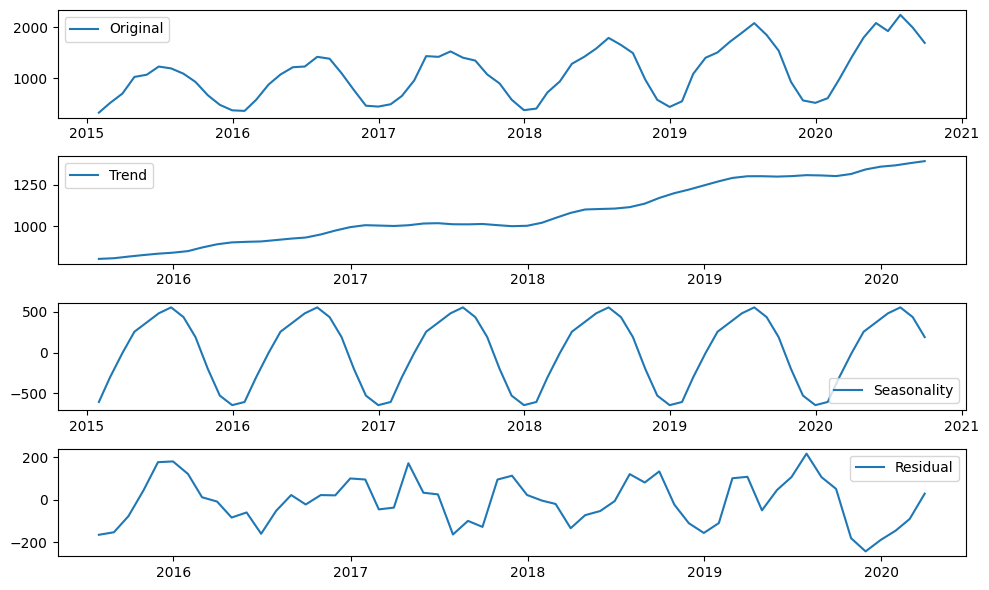

In [253]:
plt.figure(figsize=(10, 6))
plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residual')
plt.legend(loc='best')
plt.tight_layout()

I'm doing the same here, but with plotly

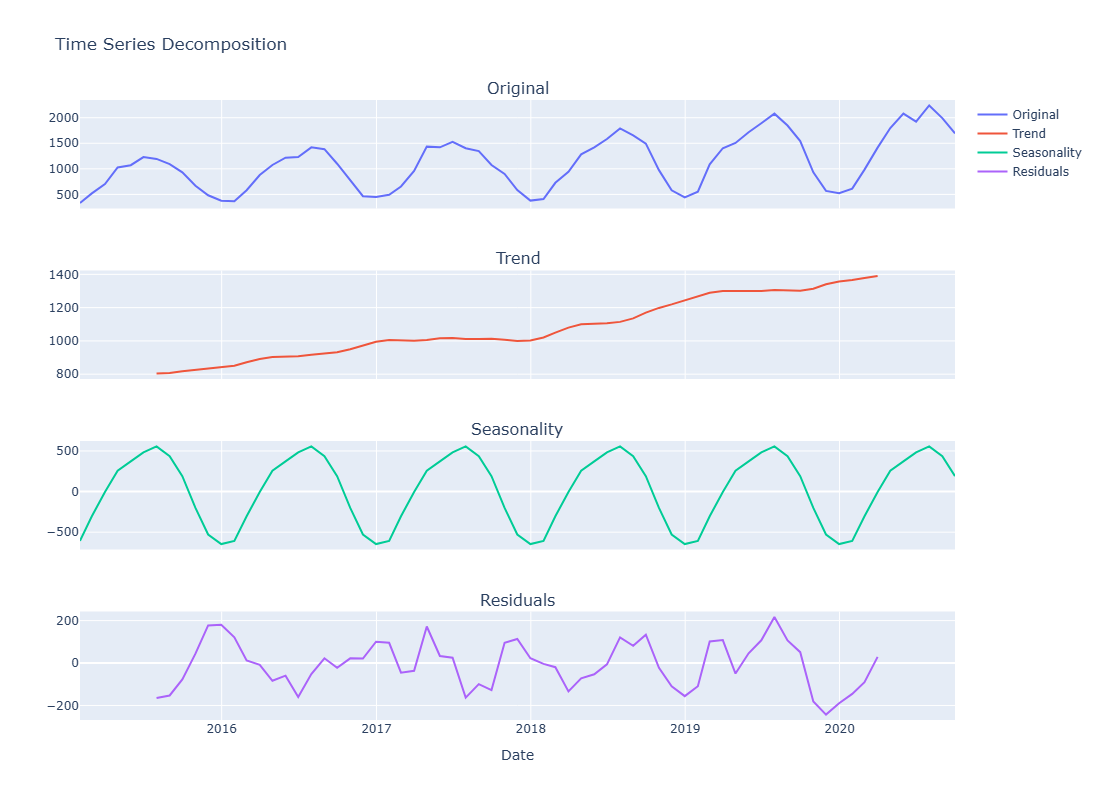

In [254]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots: 3 rows, 1 column
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.1,
                    subplot_titles=('Original', 'Trend', 'Seasonality', 'Residuals'))

# Add the first plot (Original)
fig.add_trace(go.Scatter(x=ts.index, y=ts, mode='lines', name='Original'),
              row=1, col=1)
fig.update_traces(hovertemplate='Date=%{x}<br>Value=%{y}')

# Add the second plot (Trend)
fig.add_trace(go.Scatter(x=trend.index, y=trend, mode='lines', name='Trend'),
              row=2, col=1)
fig.update_traces(hovertemplate='Date=%{x}<br>Value=%{y}')

# Add the third plot (Seasonality)
fig.add_trace(go.Scatter(x=seasonal.index, y=seasonal, mode='lines', name='Seasonality'),
              row=3, col=1)
fig.update_traces(hovertemplate='Date=%{x}<br>Value=%{y}')

fig.add_trace(go.Scatter(x=residual.index, y=residual, mode='lines', name='Residuals'),
              row=4, col=1)
fig.update_traces(hovertemplate='Date=%{x}<br>Value=%{y}')

# Update layout
fig.update_layout(height=800, width=1000, showlegend=True, title_text="Time Series Decomposition")
fig.update_xaxes(title_text="Date", row=4, col=1)  # Label x-axis only on the last plot

# Show plot
fig.show()

# Checking for Stationary

A time-series data having the mean and variance as a constant is called a stationary time series.

Removing trends or seasonality. If the time series is trending upwards, differencing will help remove that trend.

In [255]:
from statsmodels.tsa.stattools import adfuller

In [256]:
ts_log = np.log(ts)
ts_log.dropna(inplace=True)

In [257]:
s_test = adfuller(ts_log, autolag='AIC')
print("Log transform stationary check p value: ", s_test[1])

Log transform stationary check p value:  0.8939801069872018


In [258]:
ts_log

time
2015-01-31 00:00:00+00:00    5.799677
2015-02-28 00:00:00+00:00    6.252818
2015-03-31 00:00:00+00:00    6.555273
2015-04-30 00:00:00+00:00    6.935360
2015-05-31 00:00:00+00:00    6.976814
                               ...   
2020-05-31 00:00:00+00:00    7.640601
2020-06-30 00:00:00+00:00    7.561952
2020-07-31 00:00:00+00:00    7.714448
2020-08-31 00:00:00+00:00    7.597380
2020-09-30 00:00:00+00:00    7.434390
Freq: ME, Length: 69, dtype: float64

In [259]:
ts_log.shift()

time
2015-01-31 00:00:00+00:00         NaN
2015-02-28 00:00:00+00:00    5.799677
2015-03-31 00:00:00+00:00    6.252818
2015-04-30 00:00:00+00:00    6.555273
2015-05-31 00:00:00+00:00    6.935360
                               ...   
2020-05-31 00:00:00+00:00    7.494204
2020-06-30 00:00:00+00:00    7.640601
2020-07-31 00:00:00+00:00    7.561952
2020-08-31 00:00:00+00:00    7.714448
2020-09-30 00:00:00+00:00    7.597380
Freq: ME, Length: 69, dtype: float64

In [260]:
#Take first difference:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)

Text(0, 0.5, 'First order log diff')

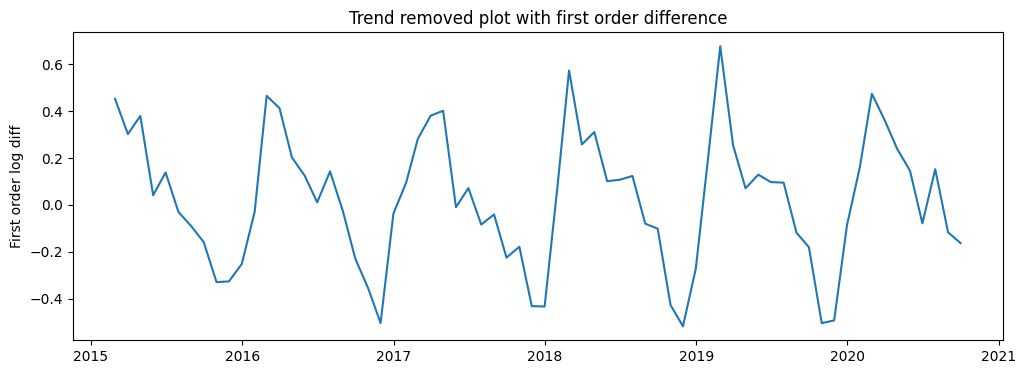

In [261]:
plt.title('Trend removed plot with first order difference')
plt.plot(ts_log_diff)
plt.ylabel('First order log diff')

In [262]:
s_test = adfuller(ts_log_diff, autolag='AIC')
print("First order difference stationary check p value: ", s_test[1])

First order difference stationary check p value:  2.026752009993417e-12


# Autocorrelation Test

In [263]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Text(0.5, 0, 'Lags')

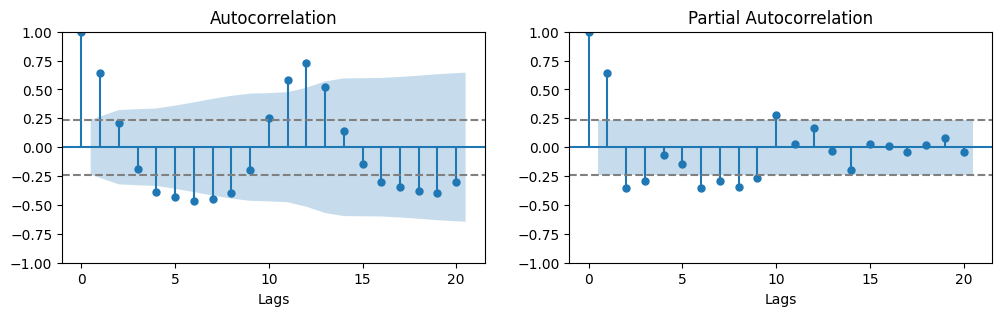

In [264]:
# ACF chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,3))
fig = plot_acf(ts_log_diff.values.squeeze(), lags=20, ax=ax1)
# draw 95% confidence interval line
ax1.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
ax1.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
ax1.set_xlabel('Lags')

# PACF chart
fig = plot_pacf(ts_log_diff, lags=20, ax=ax2)
# draw 95% confidence interval line
ax2.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
ax2.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
ax2.set_xlabel('Lags')

**ACF**: The gradual decay in the ACF plot suggests that there is some autocorrelation in the data, which might indicate the presence of a moving average (MA) component. The significant spikes at lag 1 suggest that the time series is correlated with its first lag, while the other spikes may point to short-term dependencies.
<br>
**PACF**: The sharp drop after lag 1 in the PACF plot suggests that an autoregressive (AR) model with a lag of 2 might fit the data well.

So, we might consider an ARIMA model with:
- p (AR term) = 2: Since the PACF shows significant drop at lag 2.
- d (differencing term) = 1: Since we differenced once to remove non-stationarity.
- q (MA term) = 1 or 2: The ACF shows significant spikes at lag 1 and other lags, indicating a potential moving average component of 1 or 2.

# Build and Evaluate ARIMA model

## ARIMA without first order differencing

In [265]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [266]:
# model = ARIMA(ts_log, order=(1,0,1))
# results_arima = model.fit()

In [267]:
# print("AIC:", results_arima.aic)
# print("BIC:", results_arima.bic)

In [268]:
train_size = int(len(ts_log) * 0.8)
train, test = ts_log[:train_size], ts_log[train_size:]

#### ARIMA (1,0,1)   *(just for testing)*

In [269]:
model = ARIMA(train, order=(1,0,1))
results_arima = model.fit()
# print(results_arima.summary())

In [270]:
ts_predict = results_arima.forecast(steps=len(test))

print("AIC:", results_arima.aic)
print("BIC:", results_arima.bic)

rmse = root_mean_squared_error(test, ts_predict)
mae = mean_absolute_error(test, ts_predict)
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print("Durbin-Watson statistic :", durbin_watson(results_arima.resid))

AIC: -4.129624768363724
BIC: 3.8997079725661603
Root Mean Squared Error: 0.6084806177102746
Mean Absolute Error: 0.5391623395651719
Durbin-Watson statistic : 1.5887201993742517


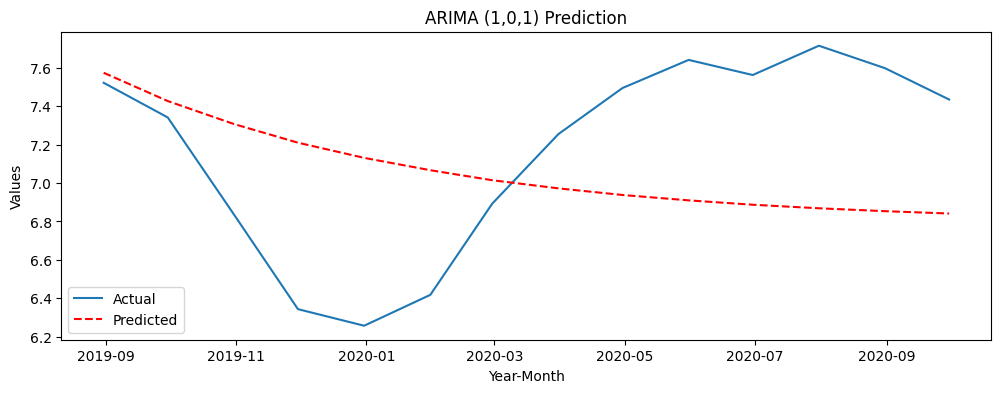

In [271]:
plt.title('ARIMA (1,0,1) Prediction')
plt.plot(test, label='Actual')
plt.plot(ts_predict, 'r--', label='Predicted')
plt.xlabel('Year-Month')
plt.ylabel('Values')
plt.legend(loc='best')

#### ARIMA (2,0,2)

In [272]:
model = ARIMA(train, order=(2,0,2))
results_arima = model.fit()
# print(results_arima.summary())

In [273]:
ts_predict = results_arima.forecast(steps=len(test))
# ts_predict = results_arima.predict(steps=len(test))

print("AIC:", results_arima.aic)
print("BIC:", results_arima.bic)

rmse = root_mean_squared_error(test, ts_predict)
mae = mean_absolute_error(test, ts_predict)
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print("Durbin-Watson statistic :", durbin_watson(results_arima.resid))

AIC: -24.104703004244513
BIC: -12.060703892849688
Root Mean Squared Error: 0.4117868869484454
Mean Absolute Error: 0.35641662917453515
Durbin-Watson statistic : 1.859903862163205


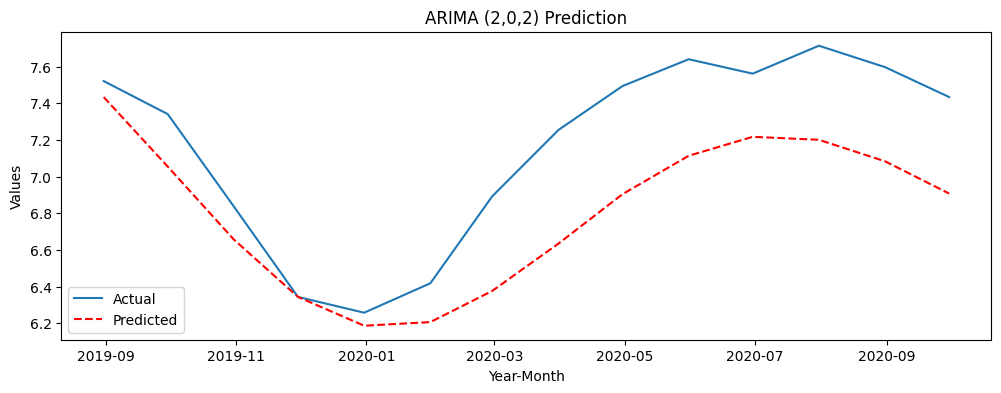

In [274]:
plt.title('ARIMA (2,0,2) Prediction')
plt.plot(test, label='Actual')
plt.plot(ts_predict, 'r--', label='Predicted')
plt.xlabel('Year-Month')
plt.ylabel('Values')
plt.legend(loc='best')

## ARIMA with first-order differencing

In [275]:
model = ARIMA(train, order=(2,1,2))
results_arima = model.fit()
# print(results_arima.summary())

In [276]:
ts_predict = results_arima.forecast(steps=len(test))
# ts_predict = results_arima.predict(steps=len(test))

print("AIC:", results_arima.aic)
print("BIC:", results_arima.bic)

rmse = root_mean_squared_error(test, ts_predict)
mae = mean_absolute_error(test, ts_predict)
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print("Durbin-Watson statistic :", durbin_watson(results_arima.resid))

AIC: -24.55404334468107
BIC: -14.609123111859695
Root Mean Squared Error: 0.3169960925249691
Mean Absolute Error: 0.2844650200815978
Durbin-Watson statistic : 0.8955218621274833


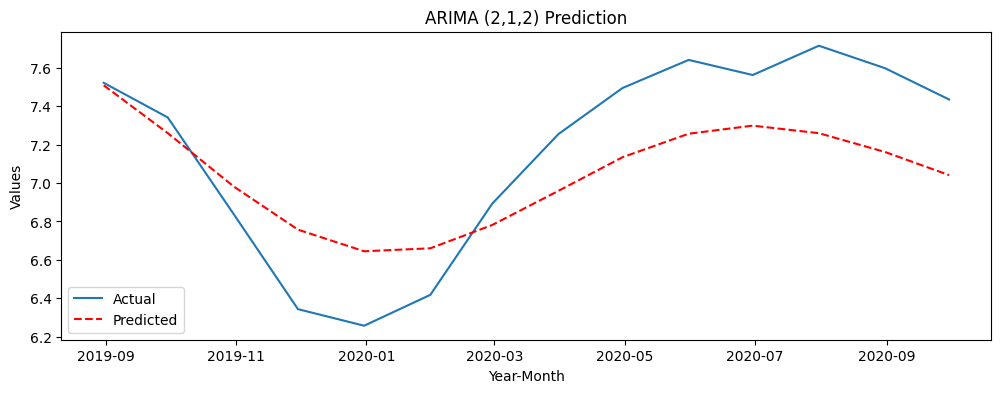

In [277]:
plt.title('ARIMA (2,1,2) Prediction')
plt.plot(test, label='Actual')
plt.plot(ts_predict, 'r--', label='Predicted')
plt.xlabel('Year-Month')
plt.ylabel('Values')
plt.legend(loc='best')

## Predictions

The ARIMA (2,0,2) is the best one so far.
<br>
Even though the ARIMA (2,1,2) has slighlty better metrics, but the the ARIMA (2,0,2) has a significantly better Durbin-Watson value.
- Durbin-Watson statistic for ARIMA (2,0,2): 1.859903862163205 (the closer to 2 the better)
- Durbin-Watson statistic for ARIMA (2,1,2): 0.8955218621274833.
  

We will use the ARIMA (2,0,2) to make predictions.

In [228]:
model = ARIMA(train, order=(2,0,2))
results_arima = model.fit()

In [229]:
ts_predict = results_arima.forecast(steps=len(test))

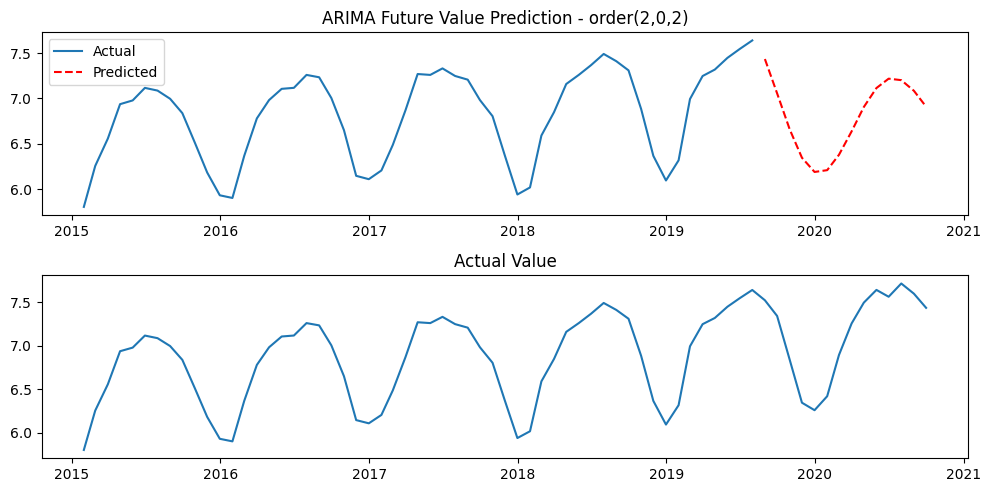

In [246]:
plt.figure(figsize=(10, 5))
plt.subplot(2,1,1)
plt.title('ARIMA Future Value Prediction - order(2,0,2)')
plt.plot(train, label='Actual')
plt.plot(ts_predict, 'r--', label='Predicted')
plt.legend(loc='best')

plt.subplot(2,1,2)
plt.title('Actual Value')
plt.plot(ts_log)

plt.tight_layout(pad=1)